# UMAP solver

uses the models generated in youmap.ipynb


In [1]:
import umap
import math
import dataclasses
import pickle
import random
import numpy as np
import os
import time
import multiprocessing
from joblib import Parallel, delayed
import re
from functools import lru_cache
from annoy import AnnoyIndex
from tqdm.notebook import tqdm
from scipy.spatial.distance import euclidean, pdist, squareform
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import cosine as cos_dist
from sklearn.preprocessing import normalize, StandardScaler
from gensim import models
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic
from typing import *

In [2]:
DATA_DIR = '/mnt/Spookley/datasets/semantle/'

In [16]:
def read_goog_file(size=None):
    vec_file = DATA_DIR + 'GoogleNews-vectors-negative300.bin'
    kv = models.KeyedVectors.load_word2vec_format(vec_file, binary=True, limit=size)
    words = kv.index_to_key
    w_vecs = {}
    good_word = re.compile(r'^[a-z]+$')
    for w in words:
        # filter out proper nouns, pictograms, emoji, multi-words, etc. Eliminates 95% of the dataset.   
        if not good_word.match(w):
            continue
        w_vecs[w] = kv[w] / np.linalg.norm(kv[w])
    mat_full = np.array([w_vecs[w] for w in w_vecs])
    w_list = list(w_vecs.keys())
    return w_list, normalize(mat_full, axis=1)

w_list, orig_mat = read_goog_file()

In [17]:
# get stuff we need from prior experiments
with open(DATA_DIR+'w_list_155060.pkl', 'rb') as fh:
    w_list = pickle.load(fh)

umap_files = []
for fn in os.listdir(DATA_DIR):
    if fn.startswith('umap_155060'):
        umap_files.append(fn)

@dataclasses.dataclass
class UMAPFile():
    name: str
    rows: int
    dims: int
    nns: int
    curve: list


with open(DATA_DIR+'umap_curves.pkl', 'rb') as fh:
    curves = pickle.load(fh)
for c in curves:
    c.name = DATA_DIR + c.name.split('/')[-1]


In [5]:
# core semantle-solver stuff
def build_index(w_vecs: Dict[str, List[float]]) -> Tuple[Dict[int, str], AnnoyIndex]:
    for v in w_vecs.values():
        GLOVE_VEC_SIZE = len(v)
        break
    idx_to_word = {}
    ann_index = AnnoyIndex(GLOVE_VEC_SIZE, 'euclidean')
    with tqdm(total=len(w_vecs)) as pbar:
        for i, w in enumerate(w_vecs.keys()):
            pbar.update(1)
            ann_index.add_item(i, w_vecs[w])
            idx_to_word[i] = w
    ann_index.build(20) # n trees
    return idx_to_word, ann_index

In [6]:
def random_point_in_dist(point, dist):
    # For when we know the dist but have no idea what direction to travel
    vec = np.random.random((len(point)))
    vec = vec / scipy.linalg.norm(vec)
    vec = vec * dist*0.5
    return vec+point


def directed_point_in_dist(p1, p2, p1_dist, p2_dist):
    # Generate a vector using p1 and p2.
    # Check if it will point in the general direction of our target.
    p1p2 = (p1-p2)
    p1p2mag = scipy.linalg.norm(p1p2)
    if p1p2mag < 0.0000001:
        return None, 0
    p1p2_unit = p1p2 / p1p2mag
    if p1_dist < p2_dist:
        # p1 is closer to target
        mag = p1_dist
        target_point = p1 + p1p2_unit*mag
        confidence = (p2_dist-p1_dist) / p1p2mag
        assert confidence >= 0
    else:
        # j is closer to target
        # make a vector from j to a target that is dists[j] away
        mag = p2_dist
        target_point = p2 - p1p2_unit*mag
        confidence = (p1_dist-p2_dist) / p1p2mag
        assert confidence >= 0
    return target_point, confidence

In [7]:
def score_to_dist(score: float, curve: List[float]):
    # convert a [-100..100] semantle score (which is cos sim * 100) to a euclidean distance in reduced space
    c_dist = 1 - (score / 100)
    p3, p2, p1 = curve
    y = p3 / (1 + np.exp(-p2*(c_dist-p1)))
    return y


In [8]:
class SemantleGame():
    def __init__(self, w_list):
        self.orig_mat = orig_mat
        self.w_list = w_list
        self.target_word = random.choice(['banana', 'leaving', 'three', 'fortunate', 'electric', 'ended', 'swim', 
       'retch', 'flute', 'hands', 'trench', 'painful', 'airborne', 'safety', 'give',
       'never', 'ferocious', 'splitter', 'raccoon', 'pickle', 'microphone', 'love',
       'zombie', 'undulate', 'semicircle', 'book', 'doctor', 'arrow', 'fridge', 'merry',
       'crank', 'similar', 'flew', 'knock', 'neighbor', 'cell', 'cloud', 'moon', 'zebra',
       'therefore', 'abrupt', 'rend', 'knife', 'shill', 'dollar', 'spilled', 'carpet',
       'lunatic', 'beach', 'revert', 'future', 'nigh', 'drake', 'winded', 'play', 'freedom'])
        idx = w_list.index(self.target_word)
        self.target_vec = orig_mat[idx, :]
        
    def guess(self, word, orig_mat) -> Tuple[bool, float]:
        # construct guess
        idx = self.w_list.index(word)
        vec = orig_mat[idx, :]
        semantle_score = (1-cos_dist(vec, self.target_vec))*100
        if word == self.target_word:
            return True, semantle_score
        else:
            return False, semantle_score
    
    def display_guesses(self):
        s = []
        for g in sorted(self.guesses, key = lambda g: g.dist):
            s.append(str(g))
        print('\n'.join(s))
        
    def __str__(self):
        return '\n'.join('{}: {}'.format(k, v) for k, v in self.__dict__.items())

In [22]:
@dataclasses.dataclass
class Guess:
    word: str
    num: int
    dist: float
    score: float
    
class SemantleSolver:
    
    def __init__(self, curve=None, n_random_guesses=5, game=None, conf_thresh=0.1, first_guess=None):
        self.first_guess = first_guess
        self.n_random_guesses = n_random_guesses
        self.closest_dist = float('inf')
        self.guesses = []  # List[Guess]
        self.guessed_words = set()  # for fast lookup
        self.best_guess = None
        self.game = game
        self.curve = curve
        
        self.CONF_THRESH = conf_thresh
        
        self.stats = {
            'grd_high_conf': 0,
            'grd_random_dist': 0,
            'times_gradient': 0,
            'times_exhaustive': 0,
            'times_random': 0,
        }
        
    def _gradient_method(self, w_vecs, ann_index):
        # Use gradient method to get a closer guess.
        p1 = np.array(w_vecs[self.guesses[-1].word])
        p1_dist = self.guesses[-1].dist
        
        # Consider the few most recent points. 
        # Try and find one with a vector through p1 that points towards the target.
        best_point = None
        best_confidence = 0
        best_p2_dist = float('inf')
        
        ####
        
        
        ####
        
        # This window thing is important!
        
        ####
        
        
        ####
        for i in range(2, min(1000, len(self.guesses))):
            p2 = np.array(w_vecs[self.guesses[-i].word])
            p2_dist = self.guesses[-i].dist
            
            # where does p2->p1 point? and how well aligned is that spot with the target?
            target_point, confidence = directed_point_in_dist(p1, p2, p1_dist, p2_dist)
            if confidence > best_confidence:
                best_confidence = confidence
                best_point = target_point
        if best_confidence < self.CONF_THRESH:
            self.stats['grd_random_dist'] += 1
            vec = np.array(w_vecs[self.best_guess])
            best_point = random_point_in_dist(vec, self.closest_dist)
            #print('grd_rand')
        else:
            self.stats['grd_high_conf'] += 1
            #print('grd_conf')

        return best_point

    
    def find_next_guess(self, w_vecs, ann_index, idx_to_word) -> bool:
        if len(self.guesses) == 0:
            next_word = self.first_guess
        elif len(self.guesses) < self.n_random_guesses:
            self.stats['times_random'] += 1
            next_word = random.choice(list(w_vecs.keys()))
        else:
            self.stats['times_gradient'] += 1
            v = self._gradient_method(w_vecs, ann_index)
            idxs_near_best = ann_index.get_nns_by_vector(v, 1000)
            for idx in idxs_near_best:
                w = idx_to_word[idx]
                if w not in self.guessed_words:
                    next_word = w
                    break
            
        return next_word

    def make_guess(self, word, orig_mat):
        # guess the word
        win, score = self.game.guess(word, orig_mat)
        dist = score_to_dist(score, self.curve)
        self.guessed_words.add(word)
        self.guesses.append(Guess(word=word, dist=dist, num=len(self.guesses)+1, score=score))
        
        # see if this one's better
        if self.best_guess is None or dist < self.closest_dist:
            #print(word, round(dist, 3))
            self.closest_dist = dist
            self.best_guess = word
        
        if win:
            #print("I win!")
            return True
        else:
            return False
    
    def add_guess(self, word, score):
        # Adds a guess from an external source. For playing Real Semantle.
        dist = score_to_dist(score, self.curve)
        self.guessed_words.add(word)
        self.guesses.append(Guess(word=word, dist=dist, num=len(self.guesses)+1, score=score))
        if self.best_guess is None or dist < self.closest_dist:
            #print(word, round(dist, 3))
            self.closest_dist = dist
            self.best_guess = word
        

In [23]:
def set_up(src, curves):
    curve = []
    for c in curves:
        if src in c.name:
            curve = c.curve
    assert len(curve)
    mat = np.load(src)

    n_words = mat.shape[0]
    wfile = DATA_DIR + 'w_list_{}.pkl'.format(n_words)
    with open(wfile, 'rb') as fh:
        w_list = pickle.load(fh)
    
    # ugh, fine.
    w_vecs = {}
    for i in range(mat.shape[0]):
        w_vecs[w_list[i]] = mat[i, :]
    idx_to_word, ann_index = build_index(w_vecs)  # fast
    return mat, w_vecs, curve, w_list, idx_to_word, ann_index

mat, w_vecs, curve, w_list, idx_to_word, ann_index = set_up(DATA_DIR+'umap_155060rows_10dims_50nns.npy', curves)

  0%|          | 0/155060 [00:00<?, ?it/s]

In [24]:
# UMAP is having trouble at the start because of its lack of global structure. 
# If we seed it with a hint (e.g one that another method would come up with), does it start to shine?

@dataclasses.dataclass
class WordPair():
    w1: str
    w2: str
    dist: float
    
    def __str__(self):
        return '{} -> {}: {}'.format(self.w1, self.w2, self.dist)

with open(DATA_DIR+'word_pairs.pkl', 'rb') as fh:
    word_pairs = pickle.load(fh)

hints = {}
for w in word_pairs:
    if 0.45 < w.dist < 0.55:
        hints[w.w1] = w.w2

for w in word_pairs:
    if 0.55 < w.dist < 0.6:
        if not hints.get(w.w1, False):
            hints[w.w1] = w.w2


fridge
{'grd_high_conf': 123, 'grd_random_dist': 1, 'times_gradient': 124, 'times_exhaustive': 0, 'times_random': 9}
never
{'grd_high_conf': 24, 'grd_random_dist': 1, 'times_gradient': 25, 'times_exhaustive': 0, 'times_random': 9}
nigh
{'grd_high_conf': 242, 'grd_random_dist': 10, 'times_gradient': 252, 'times_exhaustive': 0, 'times_random': 9}
pickle
{'grd_high_conf': 972, 'grd_random_dist': 18, 'times_gradient': 990, 'times_exhaustive': 0, 'times_random': 9}
give
{'grd_high_conf': 780, 'grd_random_dist': 50, 'times_gradient': 830, 'times_exhaustive': 0, 'times_random': 9}
ended
{'grd_high_conf': 114, 'grd_random_dist': 6, 'times_gradient': 120, 'times_exhaustive': 0, 'times_random': 9}
winded
{'grd_high_conf': 352, 'grd_random_dist': 2, 'times_gradient': 354, 'times_exhaustive': 0, 'times_random': 9}
neighbor
{'grd_high_conf': 314, 'grd_random_dist': 5, 'times_gradient': 319, 'times_exhaustive': 0, 'times_random': 9}
painful
{'grd_high_conf': 93, 'grd_random_dist': 1, 'times_gradient

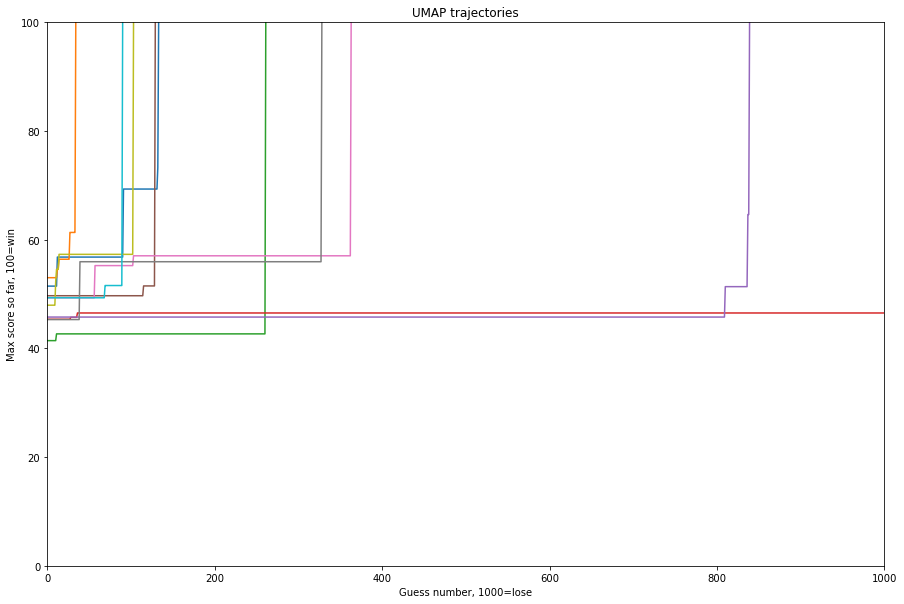

In [25]:
plt.figure(figsize=(15,10))

for _ in range(10):
    game = SemantleGame(w_list)
    game.target_word
    player = SemantleSolver(game=game, curve=curve, n_random_guesses=10, 
                            conf_thresh=0.9, first_guess=hints[game.target_word])
    print(game.target_word)
    won = False
    while not won:
        word = player.find_next_guess(w_vecs, ann_index, idx_to_word)
        won = player.make_guess(word, orig_mat)
        g = player.guesses[-1]
        local_dist = score_to_dist(g.score, curve)
        #print(g.word, round(g.score, 3), '->', round(local_dist, 3))
        if len(player.guesses) >= 1000:
            #print('stopped. ')
            #print('Best guess:', player.best_guess, 'dist:', player.closest_dist)
            break
    print(player.stats)

    max_score = 0
    traj = []
    for g in player.guesses:
        max_score = max(g.score, max_score)
        traj.append(max_score)
        
    plt.plot(range(len(traj)), traj, '-')
    plt.xlim(0, 1000)
    plt.ylim(0, 100)
    plt.title('UMAP trajectories')
    plt.ylabel('Max score so far, 100=win')
    plt.xlabel('Guess number, 1000=lose')

# Trying all the umaps to find the best one

10 and 30 dims @ 50nns did the best, though none of them did great.

In [14]:
ngs = {}
for c in curves:
    if '155' not in c.name:
        # just solving the reduced dataset here.
        continue
    if not len(c.curve):
        continue
    mat, w_vecs, curve, w_list, idx_to_word, ann_index = set_up(c.name, curves)
    ngs[c.name] = []
    for i in range(25):
        game = SemantleGame(w_list)
        player = SemantleSolver(game=game, curve=curve, n_random_guesses=2, conf_thresh=0.6)
        print(game.target_word)
        #print(player.CONF_THRESH)
        won = False
        while not won:
            word = player.find_next_guess(w_vecs, ann_index, idx_to_word)
            won = player.make_guess(word, orig_mat)
            #g = player.guesses[-1]
            #local_dist = score_to_dist(g.score, curve)
            #print(g.word, round(g.score, 3), '->', round(local_dist, 3))
            if len(player.guesses) >= 1000:
                #print('stopped. ')
                #print('Best guess:', player.best_guess, 'dist:', player.closest_dist)
                break

        #print(len(player.guesses))
        ngs[c.name].append(len(player.guesses))
    v = ngs[c.name]
    print(c.name.split('/')[-1])
    print(v)
    print("PASSED:", sum(1 for r in v if r != 1000), '/', len(v))
for k, v in ngs.items():
    print(sum(v)/len(v), k.split('/')[-1])

  0%|          | 0/155060 [00:00<?, ?it/s]

knife


ValueError: None is not in list

In [ ]:
# 10 and 30 dims did fine really. Splitting hairs beyond that.
best_ones = ['umap_155060rows_10dims_50nns.npy', 'umap_155060rows_30dims_50nns']